# Imports

In [1]:
import json
import math
import os

import copy
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

import torchvision
from torchvision.transforms import ToTensor, v2
from torchvision.datasets import INaturalist
from torchvision import models

# from torchinfo import summary

import webdataset as wds

# Checking device

In [2]:
print("CUDA available?", torch.cuda.is_available())
print("Device name:", torch.cuda.get_device_name(0))
print("Current device:", torch.cuda.current_device())

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

print("Using:", device)

CUDA available? True
Device name: NVIDIA GeForce RTX 4090
Current device: 0
Using: cuda:0


# Experiment setup

In [3]:
setup = {
    "experiment": "efficientnet_b4-10000-SGD-CELoss",
    "num_classes": 10000,
    "batch_size": 128,
    "num_workers": 16,
    "prefetch_factor": 4,
    "criterion": nn.CrossEntropyLoss(),
    "lr": 1e-4,
    "weight_decay": 1e-4,
    "momentum": 0.9,
    "max_epochs": 30
}

folder = f"./experiments/{setup['experiment']}"
os.makedirs(folder, exist_ok=True)
file_path = os.path.join(folder, 'setup.txt')

with open(file_path, 'w', encoding='utf-8') as f:
    json.dump(setup, f, indent=4, ensure_ascii=False, default=str)

print(f"Saved in: {file_path}")

tensorboard_path = f'./experiments/{setup["experiment"]}/tensorboard/'
models_path = f"./experiments/{setup['experiment']}/models/"

os.makedirs(os.path.join(tensorboard_path), exist_ok=True)
os.makedirs(os.path.join(models_path), exist_ok=True)

Saved in: ./experiments/efficientnet_b4-10000-SGD-CELoss/setup.txt


# Tensorboard functions

In [4]:
def plot_net_attributes(epoch, net, writer):
    layers = list(net.modules())

    layer_id = 1
    for layer in layers:
        if isinstance(layer, nn.Linear) :
            writer.add_histogram(f'Bias/linear-{layer_id}', layer.bias, epoch )
            writer.add_histogram(f'Weight/linear-{layer_id}', layer.weight, epoch )
            writer.add_histogram(f'Grad/linear-{layer_id}', layer.weight.grad, epoch )
            layer_id += 1

# Augmentations

In [5]:
mean = [0.4650194027653909, 0.48128506681789435, 0.37711871442015105]
std = [0.24237112423460933, 0.23366727265227194, 0.25144634756835477]

train_transform = v2.Compose([
    v2.RandomCrop((224, 224)),
    
    v2.RandomHorizontalFlip(p=0.5),
    v2.RandomVerticalFlip(p=0.5),
    v2.RandomPerspective(p=0.5),

    v2.GaussianBlur(kernel_size=3),
    v2.ColorJitter(),
    v2.RandomAutocontrast(p=0.5),
    
    ToTensor(),
    v2.ConvertImageDtype(torch.float32),
    
    v2.Normalize(mean=mean, std=std)
])

test_transform = v2.Compose([
    v2.RandomCrop((224, 224)),
    
    ToTensor(),
    v2.ConvertImageDtype(torch.float32),
    
    v2.Normalize(mean=mean, std=std)
])

## View

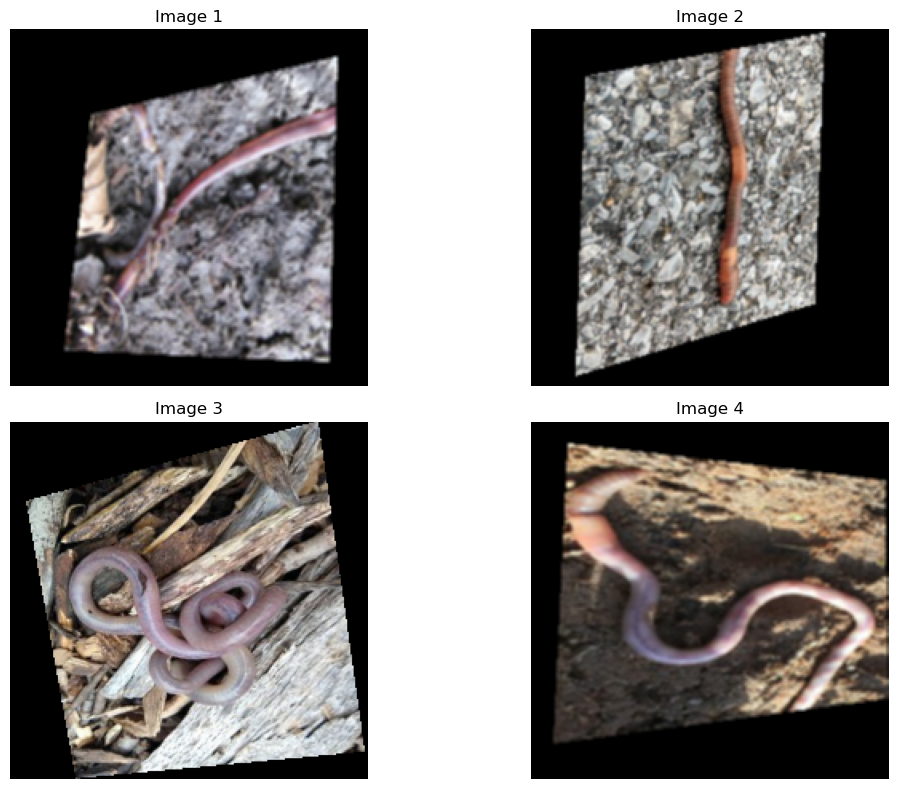

In [6]:
train_transform_view = v2.Compose([       
    v2.RandomCrop((224, 224)),
    
    v2.RandomHorizontalFlip(p=1.0),
    v2.RandomVerticalFlip(p=1.0),
    v2.RandomPerspective(p=1.0),

    v2.GaussianBlur(kernel_size=3),
    v2.ColorJitter(),
    v2.RandomAutocontrast(p=1.0),
    
    ToTensor()
])

img_dir  = "../dataset/species/2021_train_mini/00000_Animalia_Annelida_Clitellata_Haplotaxida_Lumbricidae_Lumbricus_terrestris"

img_files = [f for f in os.listdir(img_dir) if f.endswith(".jpg")]

N = 4
img_files = img_files[:N]

cols = 2
rows = N // cols + int(N % cols != 0)
fig, axes = plt.subplots(rows, cols, figsize=(6*cols, 4*rows))

for idx, img_fname in enumerate(img_files):
    img_path = os.path.join(img_dir, img_fname)
    pil = Image.open(img_path).convert("RGB")

    img_aug_tensor = train_transform_view(pil)
 
    img_np = img_aug_tensor.permute(1, 2, 0).cpu().numpy()

    r, c = divmod(idx, cols)
    ax = axes[r, c]
    ax.imshow(img_np)
    ax.set_title(f"Image {idx+1}")
    ax.axis("off")

plt.tight_layout()
plt.show()

# Dataset

## Make dataloaders

In [7]:
shard_dir = os.path.join("../dataset/species", "shards")

def decode_label(b):
    if isinstance(b, (bytes, bytearray)):
        return torch.tensor(int(b.decode('utf-8')), dtype=torch.long)
    elif isinstance(b, int):
        return torch.tensor(b, dtype=torch.long)
    else:
        raise TypeError(f"Tipo inesperado: {type(b)}")

def make_dataloader(train, filenames):
    if train:
        split = "train"
        transforms = train_transform
        num_workers = setup['num_workers']
    else:
        split = "test"
        transforms = test_transform
        num_workers = int(setup['num_workers'] / 2)
        
    pattern = os.path.join(shard_dir, split, filenames)
    
    dataset = (
        wds.WebDataset(pattern, shardshuffle=False)
        .shuffle(2000)
        .decode("pil")
        .to_tuple("jpg", "cls")
        .map_tuple(transforms, decode_label)
        .batched(setup['batch_size'], partial=torch.stack)
    )
    
    return DataLoader(
        dataset,
        batch_size=None,
        num_workers=num_workers,
        pin_memory=True,
        prefetch_factor=setup['prefetch_factor'],
        persistent_workers=True,
    )

train_dataloader = make_dataloader(train=True, filenames="data-{000000..000049}.tar")

test_dataloader = make_dataloader(train=False, filenames="data-{000000..000009}.tar")

## Get class names and size of data loaders

In [8]:
train_dataset = INaturalist(
    root='../dataset/species',
    version='2021_train_mini',
    transform=train_transform,
    download=False
)

test_dataset = INaturalist(
    root='../dataset/species',
    version='2021_valid',
    transform=test_transform,
    download=False
)

class_names = train_dataset.all_categories

short_class_names = [c.split("_")[-2] + " " + c.split("_")[-1] 
               for c in train_dataset.all_categories]

train_dataset_size = len(train_dataset)
train_dataloader_size = math.ceil(train_dataset_size / setup['batch_size'])

test_dataset_size = len(test_dataset)
test_dataloader_size = math.ceil(test_dataset_size / setup['batch_size'])

# Architecture

In [9]:
# weights = models.EfficientNet_B4_Weights.IMAGENET1K_V1

# net = models.efficientnet_b4(weights=weights)

# for param in net.parameters():
#     param.requires_grad = False

# num_features = net.classifier[1].in_features
# net.classifier[1] = nn.Linear(num_features, setup['num_classes'])

weights = models.ResNet50_Weights.IMAGENET1K_V2

net = models.resnet50(weights=weights)

for param in net.parameters():
    param.requires_grad = False

net.fc = nn.Linear(net.fc.in_features, setup['num_classes'])

## View

In [10]:
# print(net.classifier)

In [11]:
for name, param in net.named_parameters():
    if param.requires_grad == True:
        print(name, param.requires_grad)

fc.weight True
fc.bias True


In [12]:
# summary(net, input_size=(setup['batch_size'], 3, 224, 224))

# Train

In [13]:
def train(net, train_dataloader, test_dataloader, device):
  
    net.to(device)

    optimizer = torch.optim.SGD(
        filter(lambda p: p.requires_grad, net.parameters()),
        lr=setup['lr'],
        weight_decay=setup['weight_decay'],
        momentum=setup['momentum'])

    criterion = setup['criterion']
    criterion.to(device)

    writer = SummaryWriter(log_dir=tensorboard_path)
    writer.add_graph(net, next(iter(train_dataloader))[0].to(device))

    max_accuracy = -1.0

    for epoch in tqdm(range(setup['max_epochs'])):
        
        net.train()  

        train_loss, train_accuracy = [], []

        for train_batch in train_dataloader:
            
            train_x, train_label = train_batch
            train_x = train_x.to(device)
            train_label = train_label.to(device)

            optimizer.zero_grad()

            outs = net(train_x)
    
            loss = criterion(outs, train_label.long())

            train_loss.append(loss.item())
            
            loss.backward()
            optimizer.step()

            predict_labels = torch.max(outs, axis=1)[1]
            correct = torch.sum(predict_labels == train_label)
            accuracy = correct/train_label.size(0)

            train_accuracy.append(accuracy)

            plot_net_attributes(epoch, net, writer)

        train_loss = np.asarray(train_loss)
        train_accuracy = np.asarray(train_accuracy)

        val_loss, val_accuracy = validate(net, criterion, test_dataloader, device)

        writer.add_scalar('Loss/train', train_loss.mean(), epoch)
        writer.add_scalar('Loss/val', val_loss.mean(), epoch)
        writer.add_scalar('Accuracy/train', train_accuracy.mean(), epoch)
        writer.add_scalar('Accuracy/val', val_accuracy.mean(), epoch)
            
        if val_accuracy.mean() > max_accuracy:
            best_model = copy.deepcopy(net)
            max_accuracy = val_accuracy.mean()
            print(f'Saving the model with the best accuracy: {max_accuracy:3.4f}')
            
        print(f'Epoch: {epoch+1:3d} | Loss/train: {train_loss.mean():3.4f}% | Accuracy/train: {train_accuracy.mean():3.4f}% |\
            Loss/val: {val_loss.mean():3.4f}% | Accuracy/val: {val_accuracy.mean():3.4f}% |')

    path = f'{models_path}{setup["experiment"]}-{max_accuracy:.2f}.pkl'
    torch.save(best_model, path)
    print(f'Best model saved in: {path}')

    writer.flush()
    writer.close()
    
    return best_model

# Validate

In [14]:
def validate(net, criterion, test_dataloader, device):

    net.eval()
    net.to(device)

    val_loss, val_accuracy = [], []

    for test_batch in test_dataloader:

        test_x, test_label = test_batch
        test_x = test_x.to(device)
        test_label = test_label.to(device)

        with torch.no_grad():
            outs = net(test_x).detach()

        loss = criterion(outs, test_label.long())
        
        val_loss.append(loss.item())

        predict_labels = torch.max(outs, axis=1)[1]
        correct = torch.sum(predict_labels == test_label)
        accuracy = correct/test_label.size(0)

        val_accuracy.append(accuracy)
        
    val_loss = np.asarray(val_loss)
    val_accuracy = np.asarray(val_accuracy)

    return val_loss, val_accuracy

# Fit

In [15]:
best_model = train(net, train_dataloader, test_dataloader, device)

  0%|                                                                                                    | 0/30 [04:42<?, ?it/s]


KeyboardInterrupt: 